In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [5]:
# 데이터 가져오는 링크
# https://www.investing.com/equities/tesla-motors-historical-data

In [7]:
tsla = pd.read_csv('/content/TSLA.csv')

In [8]:
tsla.head()
tsla.shape

,Date,Price,Open,High,Low,Vol.,Change %
0,11/24/2023,235.45,233.75,238.75,232.33,65.03M,0.53%
1,11/22/2023,234.21,242.04,244.01,231.40,118.12M,-2.90%
2,11/21/2023,241.20,235.04,243.62,233.34,122.29M,2.38%
3,11/20/2023,235.60,234.04,237.10,231.02,116.56M,0.55%
4,11/17/2023,234.30,232.00,237.39,226.54,142.77M,0.30%


(1428, 7)

In [9]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1428 non-null   object 
 1   Price     1428 non-null   float64
 2   Open      1428 non-null   float64
 3   High      1428 non-null   float64
 4   Low       1428 non-null   float64
 5   Vol.      1428 non-null   object 
 6   Change %  1428 non-null   object 
dtypes: float64(4), object(3)
memory usage: 78.2+ KB


In [10]:
tsla.Date = pd.to_datetime(tsla.Date)
tsla = tsla.set_index('Date')

In [11]:
df = tsla.copy()
df = df[['Price']]
df = df.iloc[::-1]
df.head()

,Price
Date,
2018-03-26,20.28
2018-03-27,18.61
2018-03-28,17.19
2018-03-29,17.74
2018-04-02,16.83


In [12]:
df_check_dist = df.copy()
df_check_dist['year'] = df_check_dist.index.year
print(df_check_dist)

             Price  year
Date                    
2018-03-26   20.28  2018
2018-03-27   18.61  2018
2018-03-28   17.19  2018
2018-03-29   17.74  2018
2018-04-02   16.83  2018
...            ...   ...
2023-11-17  234.30  2023
2023-11-20  235.60  2023
2023-11-21  241.20  2023
2023-11-22  234.21  2023
2023-11-24  235.45  2023

[1428 rows x 2 columns]


In [13]:
df_check_dist.year.value_counts(sort=False)

2018    194
2019    252
2020    253
2021    252
2022    251
2023    226
Name: year, dtype: int64

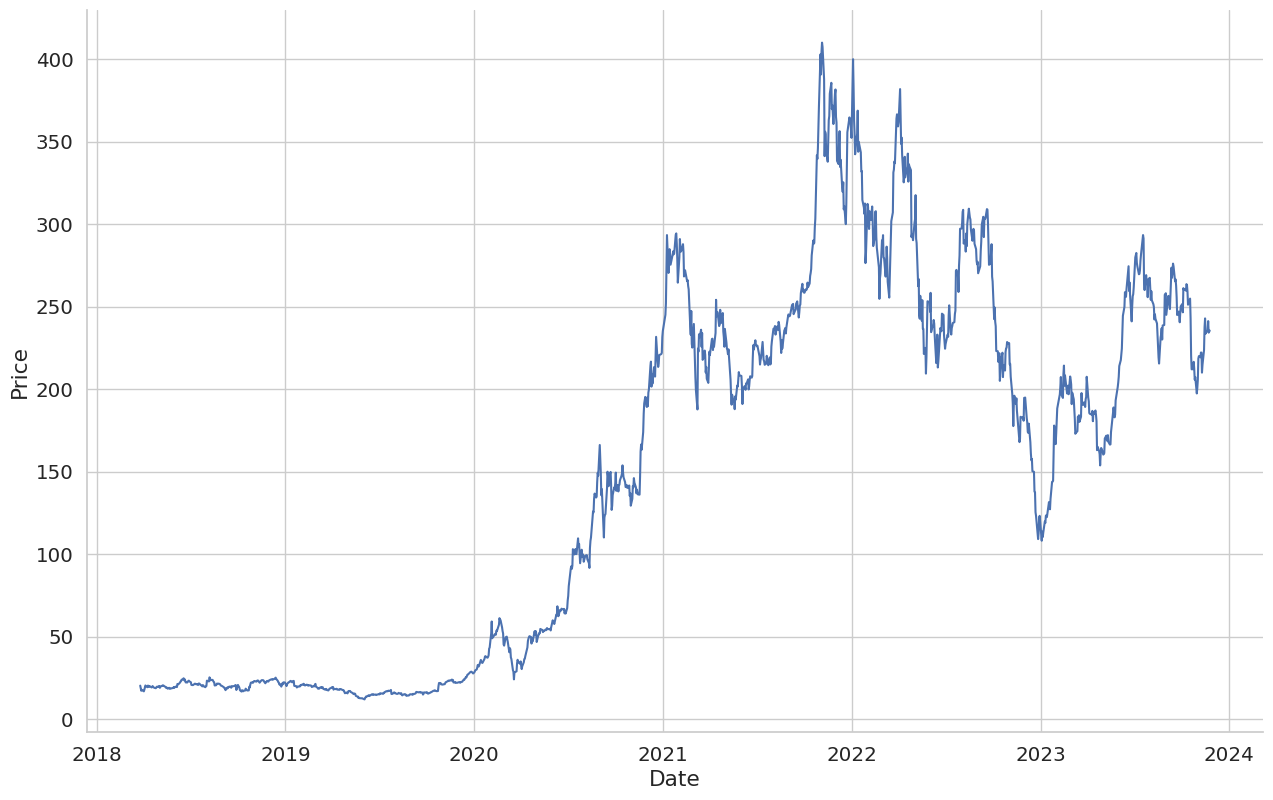

In [14]:
sns.set_theme(style="whitegrid", palette='deep', context='notebook', font_scale=1.3)
ax = sns.relplot(x=df.index, y=df.Price, kind='line', height=8.27, aspect=13/8.27)

In [35]:
df.head()


,Price
Date,
2018-03-26,20.28
2018-03-27,18.61
2018-03-28,17.19
2018-03-29,17.74
2018-04-02,16.83


In [36]:
len(df)

1428

In [37]:
def generate_sequences(df, tw, pw):
    data = {}

    for i in range(len(df)-tw):
        sequence = df[i:i+tw].values
        target = df[i+tw:i+tw+pw].values
        data[i] = {'sequence': sequence, 'target': target}
    return data


In [38]:
class SequenceDataset(Dataset):
    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [39]:
BATCH_SIZE = 16
seq_len = 30
pred_len = 1

data = df.copy()
sequences = generate_sequences(data, seq_len, pred_len)
dataset = SequenceDataset(sequences)
ld = len(dataset)


In [40]:
dataset.__getitem__(0)

(tensor([[20.2800],
         [18.6100],
         [17.1900],
         [17.7400],
         [16.8300],
         [17.8400],
         [19.1300],
         [20.3800],
         [19.9500],
         [19.3100],
         [20.3100],
         [20.0600],
         [19.6100],
         [20.0200],
         [19.4100],
         [19.1800],
         [19.5600],
         [20.0100],
         [19.3500],
         [18.8900],
         [18.9000],
         [18.7100],
         [19.0300],
         [19.6000],
         [19.5900],
         [19.9900],
         [20.0800],
         [18.9600],
         [19.6100],
         [20.1800]]),
 tensor([[20.1300]]))

In [41]:
dataset.__getitem__(0)[0].shape

torch.Size([30, 1])

In [42]:
train_split = 0.6
val_split = 0.2
train_len = int(ld*train_split)
val_len = int(ld*val_split)

lens = [train_len, val_len, ld-train_len-val_len]
train_set, val_set, test_set = random_split(dataset, lens)

In [43]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [44]:
x, y = next(iter(train_loader))
x.shape, y.shape
x[0], y[0]


(torch.Size([16, 30, 1]), torch.Size([16, 1, 1]))

(tensor([[276.5400],
         [274.4300],
         [269.6100],
         [269.7900],
         [271.9900],
         [277.9000],
         [281.3800],
         [290.3800],
         [293.3400],
         [291.2600],
         [262.9000],
         [260.0200],
         [269.0600],
         [265.2800],
         [264.3500],
         [255.7100],
         [266.4400],
         [267.4300],
         [261.0700],
         [254.1100],
         [259.3200],
         [253.8600],
         [251.4500],
         [249.7000],
         [242.1900],
         [245.3400],
         [242.6500],
         [239.7600],
         [232.9600],
         [225.6000]]),
 tensor([[219.2200]]))

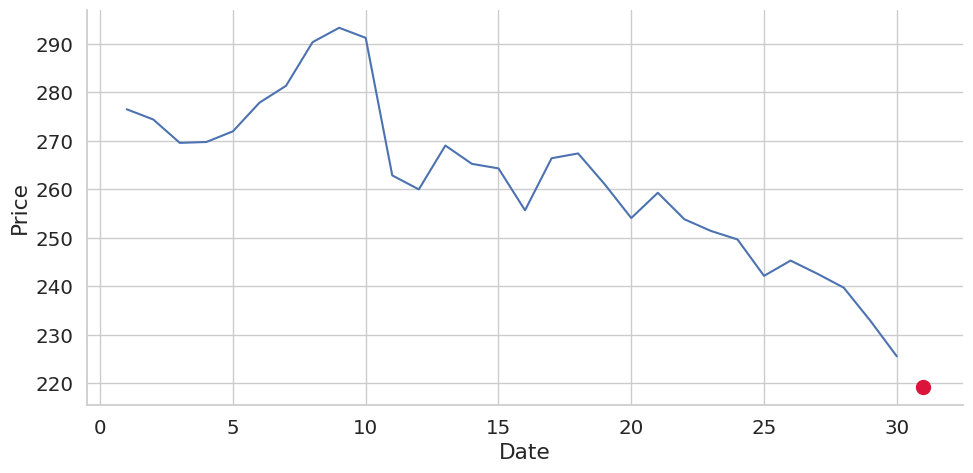

In [45]:
batch_df = pd.DataFrame({'Date': np.arange(1,seq_len+1), 'Price': x[0].numpy().reshape((1,-1))[0]})
ax = sns.relplot(data=batch_df, x='Date', y='Price', kind='line', height=5, aspect=2)
plt.plot(seq_len+1, y[0], marker="o", markersize=10, markeredgecolor="crimson", markerfacecolor="crimson")

훈련 방법

In [46]:
def metrics(outputs, labels):
    diff = outputs-labels
    mse = torch.mean(torch.square(diff))
    mae = torch.mean(torch.abs(diff))
    rmse = torch.sqrt(mse)
    return torch.tensor([mse, mae, rmse])

In [47]:
class StocksPredictionBase(nn.Module):

    def training_step(self, batch, criterion):
        x, y = batch
        x = x.to(device)
        y  = y.squeeze().to(device)
        out = self(x).squeeze()
        loss = criterion(out, y)
        return loss


    def validation_step(self, batch):
        x, y = batch
        x = x.to(device)
        y  = y.squeeze().to(device)
        out = self(x).squeeze()
        metric = metrics(out, y)
        return {'val_mse': metric[0], 'val_mae': metric[1], 'val_rmse': metric[2]}


    def validation_epoch_end(self, outputs):
        batch_mses = [x['val_mse'] for x in outputs]
        epoch_mse = torch.stack(batch_mses).mean()
        batch_maes = [x['val_mae'] for x in outputs]
        epoch_mae = torch.stack(batch_maes).mean()
        batch_rmses = [x['val_rmse'] for x in outputs]
        epoch_rmse = torch.stack(batch_rmses).mean()
        return {'val_mse': epoch_mse.item(), 'val_mae': epoch_mae.item(), 'val_rmse': epoch_rmse.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_mse: {:.4f}, val_mae: {:.4f}, val_rmse: {:.4f}".format(
            epoch, result['train_loss'], result['val_mse'], result['val_mae'], result['val_rmse']))

In [48]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func, criterion):

    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):

        model.train()
        train_losses = []

        for batch in train_loader:

            optimizer.zero_grad()
            loss = model.training_step(batch, criterion)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [49]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    outputs
    return model.validation_epoch_end(outputs)

In [50]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'

RNN 1 모델

In [51]:
class model_RNN(StocksPredictionBase):

    def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_rnn_layers, n_deep_layers, dropout, use_cuda=False):
        super().__init__()

        self.n_rnn_layers = n_rnn_layers
        self.nhid = n_hidden
        self.use_cuda = use_cuda

        self.rnn = nn.RNN(n_features,
                          n_hidden,
                          num_layers=n_rnn_layers,
                          batch_first=True)

        self.fc1 = nn.Linear(n_hidden*sequence_len, n_hidden)

        self.dropout = nn.Dropout(p=dropout)

        dnn_layers = []
        for i in range(n_deep_layers):
            if i == n_deep_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_outputs))
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))

        self.dnn = nn.Sequential(*dnn_layers)


    def forward(self, x):

        hidden_state = torch.zeros(self.n_rnn_layers, x.shape[0], self.nhid)

        if self.use_cuda:
            hidden_state = hidden_state.to(device)
        self.hidden = hidden_state

        x, h = self.rnn(x, self.hidden)
        x = self.dropout(x.contiguous().view(x.shape[0], -1))
        x = self.fc1(x)

        return self.dnn(x)

class model_LSTM(StocksPredictionBase):

    def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers, n_deep_layers, dropout, use_cuda=False):
        super().__init__()

        self.n_lstm_layers = n_lstm_layers
        self.nhid = n_hidden
        self.use_cuda = use_cuda

        self.lstm = nn.LSTM(n_features,
                            n_hidden,
                            num_layers=n_lstm_layers,
                            batch_first=True)

        self.fc1 = nn.Linear(n_hidden*sequence_len, n_hidden)

        self.dropout = nn.Dropout(p=dropout)

        dnn_layers = []
        for i in range(n_deep_layers):
            if i == n_deep_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_outputs))
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))

        self.dnn = nn.Sequential(*dnn_layers)


    def forward(self, x):

        hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
        cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

        if self.use_cuda:
            hidden_state = hidden_state.to(device)
            cell_state = cell_state.to(device)

        self.hidden = (hidden_state, cell_state)

        x, h = self.lstm(x, self.hidden)
        x = self.dropout(x.contiguous().view(x.shape[0], -1))
        x = self.fc1(x)

        return self.dnn(x)

In [96]:
# RNN Model 1

# n_input = 1
# n_neuro_in_hidden_layers = 20
# n_out = 1
# n_dnn_layers = 4
# n_rnn_layers = 1
# dropout  = 0

# RNN Model 2

# n_input = 1
# n_neuro_in_hidden_layers = 30
# n_out = 1
# n_dnn_layers = 5
# n_rnn_layers = 2
# dropout  = 0

# #RNN Model 3

# n_input = 1
# n_neuro_in_hidden_layers = 70
# n_out = 1
# n_dnn_layers = 7
# n_rnn_layers = 3
# dropout  = 0

# LSTM Model 1

# n_input = 1
# n_out = 1
# n_neuro_in_hidden_layers = 30
# n_dnn_layers = 2
# n_lstm_layers = 2
# dropout = 0

# LSTM Model 2

n_input = 1
n_out = 1
n_neuro_in_hidden_layers = 35
n_dnn_layers = 2
n_lstm_layers = 3
dropout = 0



In [97]:
# model1 = model_RNN(n_input, n_neuro_in_hidden_layers, n_out, seq_len, n_rnn_layers, n_dnn_layers, dropout, use_cuda=USE_CUDA).to(device)
# model1

# history = fit(epochs, lr, model1, train_loader, val_loader, opt_func, criterion)



In [98]:
model2 = model_LSTM(n_input, n_neuro_in_hidden_layers, n_out, seq_len, n_lstm_layers, n_dnn_layers, dropout, use_cuda=USE_CUDA).to(device)
model2

history2 = fit(epochs, lr, model2, train_loader, val_loader, opt_func, criterion)


model_LSTM(
  (lstm): LSTM(1, 35, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=1050, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (dnn): Sequential(
    (0): ReLU()
    (1): Linear(in_features=35, out_features=35, bias=True)
    (2): ReLU()
    (3): Linear(in_features=35, out_features=1, bias=True)
  )
)

Epoch [0], train_loss: 31188.2305, val_mse: 20731.2598, val_mae: 116.3488, val_rmse: 141.7965
Epoch [1], train_loss: 11941.8535, val_mse: 4906.6431, val_mae: 52.0099, val_rmse: 67.2020
Epoch [2], train_loss: 2317.1873, val_mse: 1525.5000, val_mae: 26.7800, val_rmse: 36.9348
Epoch [3], train_loss: 1037.1035, val_mse: 1080.0931, val_mae: 21.7320, val_rmse: 31.8540
Epoch [4], train_loss: 1014.7677, val_mse: 836.3646, val_mae: 18.2208, val_rmse: 27.1750
Epoch [5], train_loss: 942.6144, val_mse: 1198.7008, val_mae: 22.6692, val_rmse: 33.8937
Epoch [6], train_loss: 999.7478, val_mse: 843.7782, val_mae: 18.9047, val_rmse: 27.8183
Epoch [7], train_loss: 644.6588, val_mse: 568.5619, val_mae: 13.8639, val_rmse: 21.7020
Epoch [8], train_loss: 508.8576, val_mse: 809.2545, val_mae: 18.9987, val_rmse: 27.3458
Epoch [9], train_loss: 518.3531, val_mse: 394.5375, val_mae: 11.9435, val_rmse: 18.3110
Epoch [10], train_loss: 503.2203, val_mse: 589.0482, val_mae: 15.2087, val_rmse: 22.7022
Epoch [11], trai

In [99]:
epochs = 32
opt_func = torch.optim.Adam
criterion = nn.MSELoss().to(device)
lr = 0.001

In [100]:

#RNN
# evaluate(model1, test_loader)

#LSTM
evaluate(model2, test_loader)


{'val_mse': 155.9695587158203,
 'val_mae': 8.864202499389648,
 'val_rmse': 12.07814884185791}

In [101]:
df_loss = pd.DataFrame()
df_loss['epoch'] = np.arange(1,epochs+1)
train_mse = []
val_mse = []


#RNN

# for i in history:
#     train_mse.append(i['train_loss'])
#     val_mse.append(i['val_mse'])


#LSTM

for i in history2:
    train_mse.append(i['train_loss'])
    val_mse.append(i['val_mse'])


df_loss['train_mse'] = train_mse
df_loss['val_mse'] = val_mse

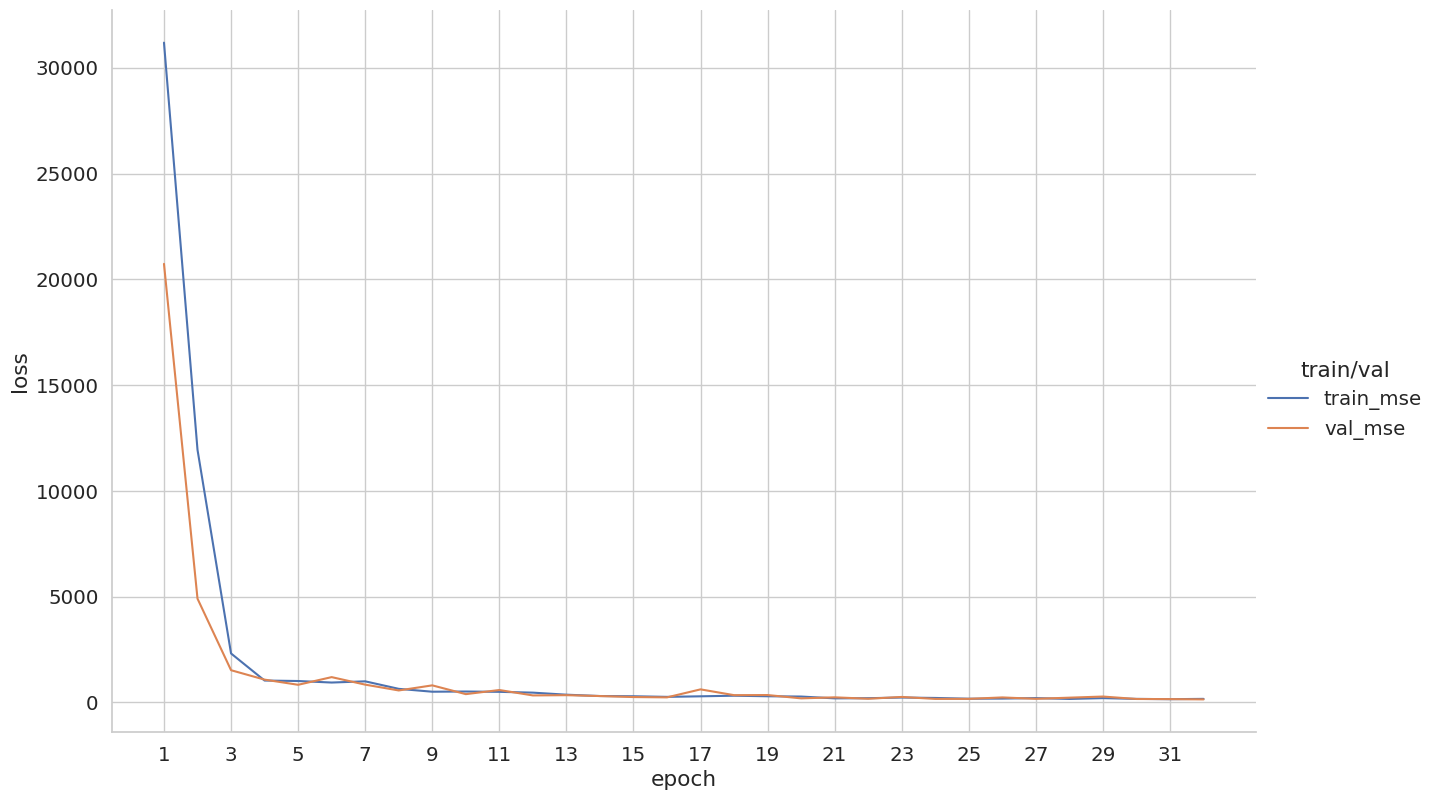

In [102]:
#epoch loss 지표
sns.set_theme(style="whitegrid", palette='deep', context='notebook', font_scale=1.3)
ax = sns.relplot(data=pd.melt(df_loss,id_vars=['epoch'],var_name='train/val',value_vars=['train_mse','val_mse'],value_name='loss'),
                 x='epoch', y='loss', hue='train/val', kind='line', height=8.27, aspect=13/8.27)
ax.set(xticks=np.arange(1,epochs+1,2))

새로운예측

In [103]:
@torch.no_grad()
def make_predictions(model, dataloader):
    model.eval()
    predictions, actuals = [], []

    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.squeeze().to(device)
        out = model(x)
        predictions.append(out)
        actuals.append(y)

    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    return predictions.squeeze(), actuals

In [104]:
dataloader_for_predicts = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
pred, y = make_predictions(model2, dataloader_for_predicts)


# scaler 오류로 인한 추가수정
### 추가↓↓↓
scaler = StandardScaler()
scaler.fit(df)
### 추가↑↑↑↑
df_pred = pd.DataFrame(np.transpose([pred,y]),columns=['predicted price','actual price'])
df_pred = pd.concat([pd.DataFrame(np.hstack((data.iloc[:30],data.iloc[:30])), columns=['predicted price','actual price']), df_pred], ignore_index=True)

df_pred['date'] = np.arange(1,len(pred)+seq_len+1)
df_pred['predicted price'] = scaler.inverse_transform(df_pred['predicted price'].values.reshape((-1,1)))
df_pred['actual price'] = scaler.inverse_transform(df_pred['actual price'].values.reshape((-1,1)))



StandardScaler()

In [105]:
df_pred = pd.DataFrame(np.transpose([pred,y]),columns=['predicted price','actual price'])
df_pred = pd.concat([pd.DataFrame(np.hstack((data.iloc[:30],data.iloc[:30])), columns=['predicted price','actual price']), df_pred], ignore_index=True)

df_pred['date'] = np.arange(1,len(pred)+seq_len+1)

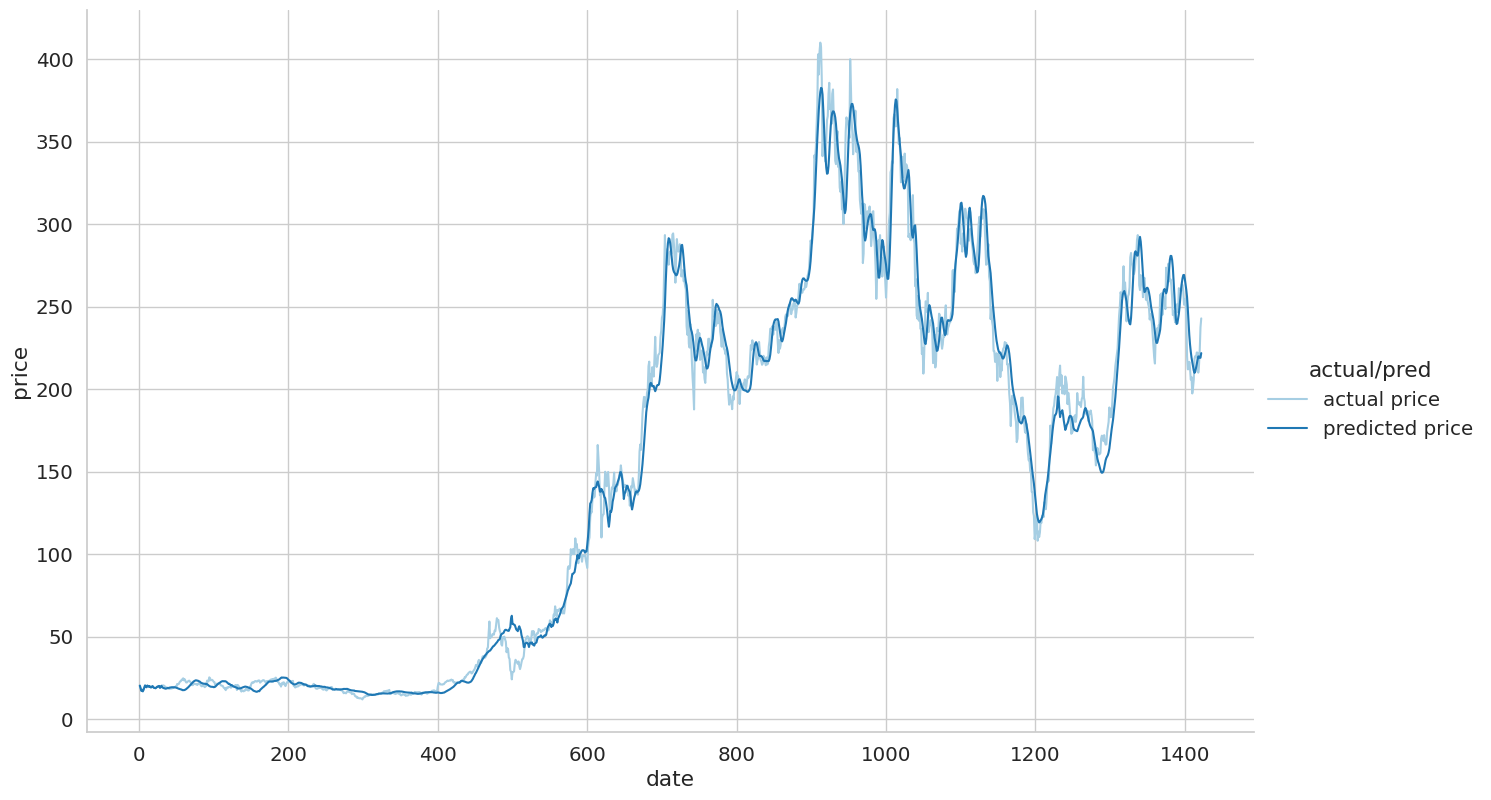

In [106]:
sns.set_theme(style="whitegrid", palette='Paired', context='notebook', font_scale=1.3)
ax = sns.relplot(data=pd.melt(df_pred,id_vars=['date'],var_name='actual/pred',value_vars=['actual price','predicted price'],value_name='price'),
                 x='date', y='price', hue='actual/pred', kind='line', height=8.27, aspect=13/8.27)

새로운 예측

In [107]:
class Forecaster:

    def __init__(self, model, data, target, tw):
        self.model = model
        self.data = data
        self.target = target
        self.tw = tw


    def plot_forecast(self, res):
        res['forecast'] = scaler.inverse_transform(res['forecast'].values.reshape((-1,1)))
        res['actual'] = scaler.inverse_transform(res['actual'].values.reshape((-1,1)))
        sns.set_theme(style="whitegrid", palette='Paired', context='notebook', font_scale=1.3)
        ax = sns.relplot(data=pd.melt(res,id_vars=['date'],var_name='actual/forecast',value_vars=['actual','forecast'],value_name='price'),
                 x='date', y='price', hue='actual/forecast', kind='line', height=8.27, aspect=13/8.27)


    def one_step_forecast(self, pre):
        self.model.eval()
        with torch.no_grad():
            pre = torch.Tensor(pre).unsqueeze(0)
            pre = pre.to(device)
            pred = self.model(pre)
        return pred.cpu().numpy().reshape(-1)


    def n_step_forecast(self, n, forecast_from=None, plot=False):
        history = self.data[self.target].to_frame()

        if forecast_from:
            pre = list(history[forecast_from - self.tw : forecast_from][self.target].values)
        else:
            pre = list(history[self.target])[-self.tw:]

        for i, step in enumerate(range(n)):
            pre_ = np.array(pre[-self.tw:]).reshape(-1, 1)
            forecast = self.one_step_forecast(pre_).squeeze()

            pre.append(forecast)

        res = history.copy()
        ls = [np.nan for i in range(len(history))]

        if forecast_from:
            ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
            res['forecast'] = ls
            res.columns = ['actual', 'forecast']
            res['date'] = np.arange(1,len(res)+1)
        else:
            fc = ls + list(np.array(pre[-n:]))
            ls = ls + [np.nan for i in range(len(pre[-n:]))]
            ls[:len(history)] = history[self.target].values
            res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
            res['date'] = np.arange(1,len(res)+1)

        if plot:
            self.plot_forecast(res)

        return res

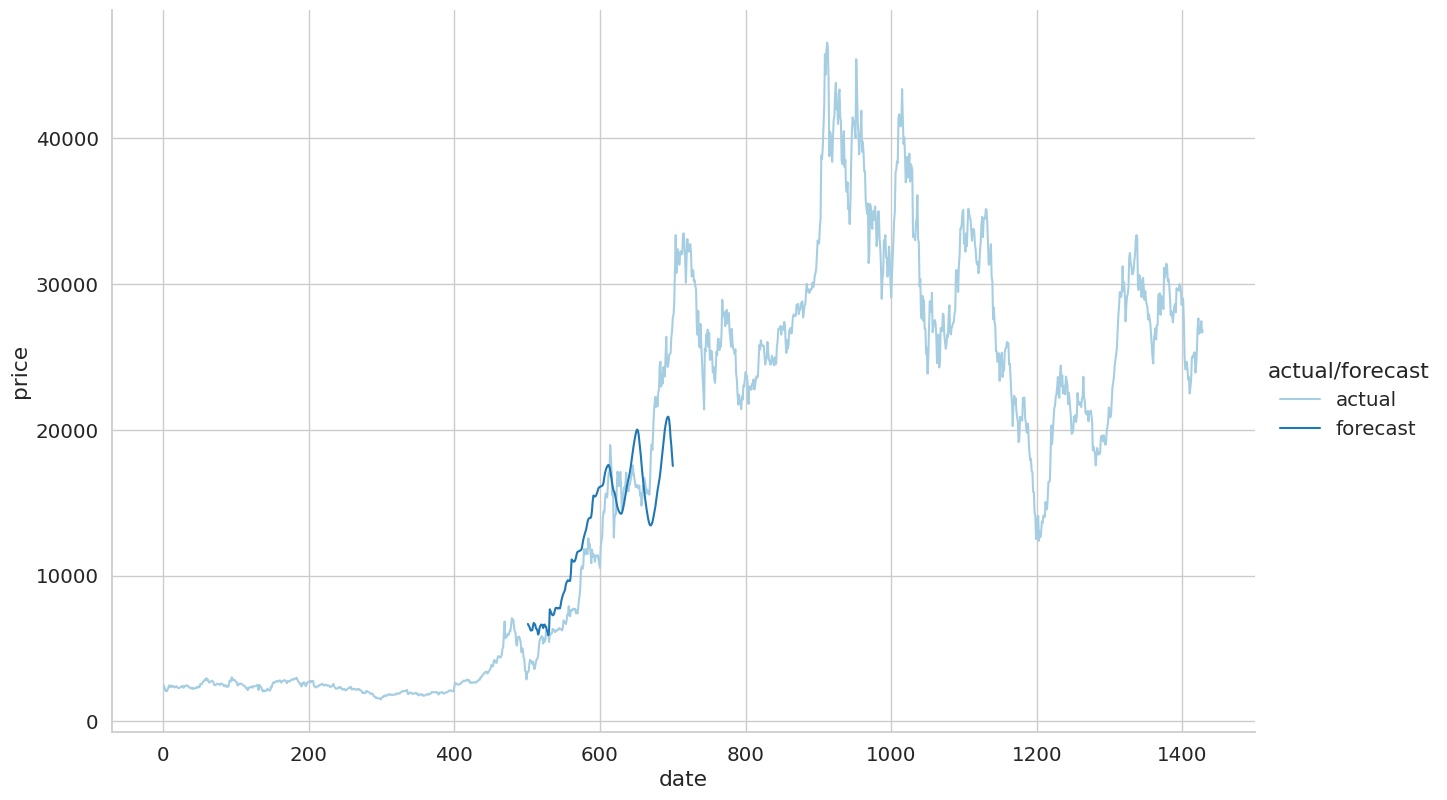

In [108]:
#RNN

# forecaster = Forecaster(model1, data, 'Price', seq_len)



#LSTM
forecaster = Forecaster(model2, data, 'Price', seq_len)


# 1. 수정한부분
# 시각화 범위 더넓히기
# 구간부분 예측 보기 편한곳으로 놓기
history = forecaster.n_step_forecast(200, 500, plot=True)


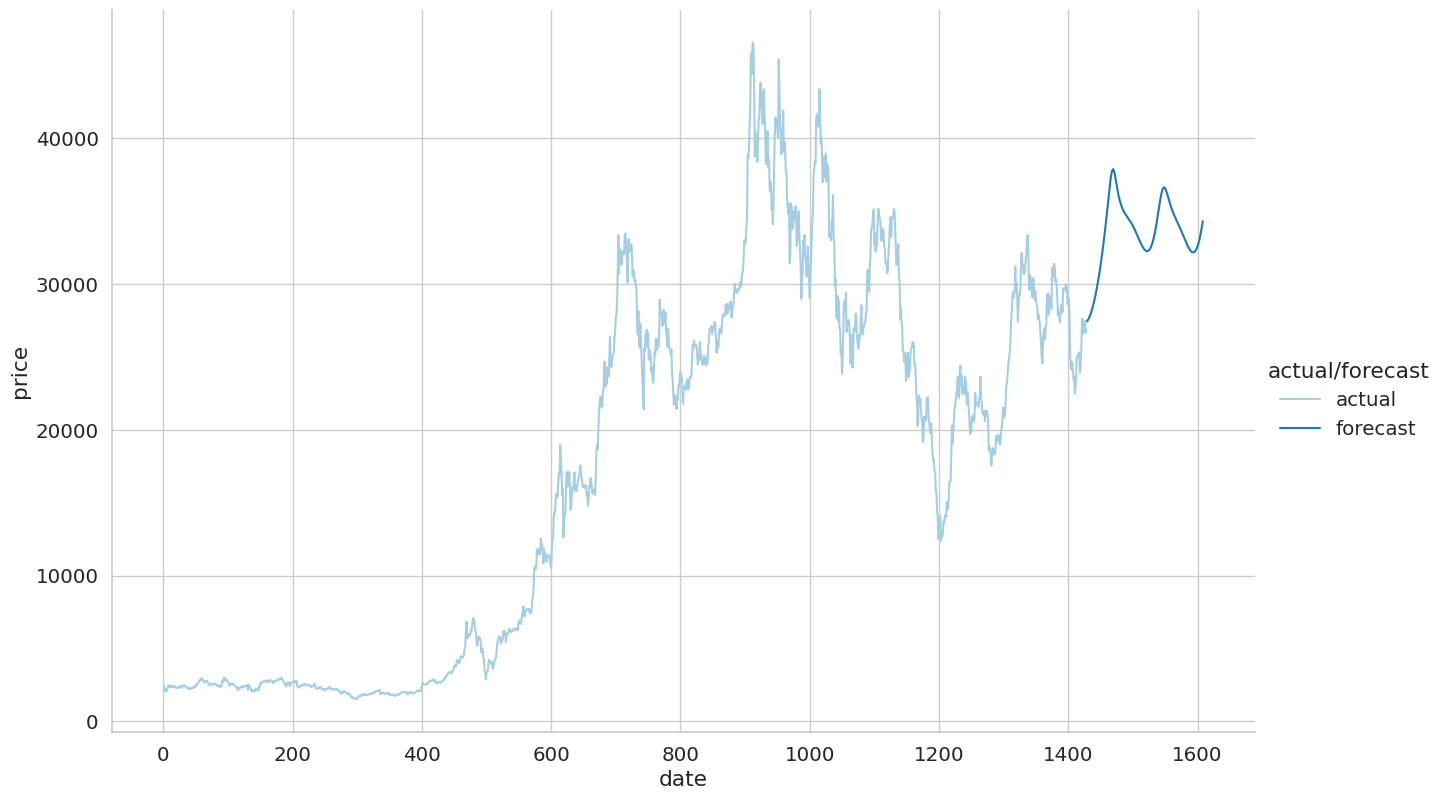

In [109]:

history = forecaster.n_step_forecast(180, plot=True)

